In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

**Data Loading & Class Weights**

In [ ]:
# Constants
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
data_dir = pathlib.Path("/content/teaLeafBD")

# 1. Create Datasets
print("Creating datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes found: {class_names}")

# 2. Calculate Class Weights
print("Calculating class weights...")
train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))
print(f"Class Weights: {class_weights}")

# 3. Optimize Datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating datasets...
Found 5276 files belonging to 7 classes.
Using 4221 files for training.
Found 5276 files belonging to 7 classes.
Using 1055 files for validation.
Classes found: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
Calculating class weights...
Class Weights: {0: np.float64(1.763157894736842), 1: np.float64(1.4707317073170731), 2: np.float64(0.7344701583434835), 3: np.float64(1.2641509433962264), 4: np.float64(1.4425837320574162), 5: np.float64(0.5958498023715415), 6: np.float64(0.8137651821862348)}


**EfficientNetB0 Model Definition**

In [ ]:
# 1. Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
])

# 2. Base Model: EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# 3. Build Model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Augmentation
x = data_augmentation(inputs)

# EfficientNet
x = base_model(x, training=False)

# Head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

**Initial Training (Frozen)**

In [ ]:
# Compile
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc']
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

# Train
print("Starting Initial Training...")
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping],
  class_weight=class_weights
)

Starting Initial Training...
Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 168ms/step - acc: 0.3988 - loss: 1.6052 - val_acc: 0.6654 - val_loss: 0.9686
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - acc: 0.6520 - loss: 1.0100 - val_acc: 0.7261 - val_loss: 0.8221
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - acc: 0.7066 - loss: 0.8783 - val_acc: 0.7602 - val_loss: 0.7491
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - acc: 0.7261 - loss: 0.8119 - val_acc: 0.7678 - val_loss: 0.6520
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - acc: 0.7468 - loss: 0.7572 - val_acc: 0.7659 - val_loss: 0.6568
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - acc: 0.7530 - loss: 0.7429 - val_acc: 0.7943 - val_loss: 0.6032
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - acc: 0.7590 - loss: 0.7229 - val_acc: 0.7886 - val_loss: 0.6112
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - acc: 0.7577 - loss: 0.6893 - val_acc: 0.7791 - val_loss: 0.6135
Epoch 9/20

**Fine-Tuning**

In [ ]:
# 1. Unfreeze
base_model.trainable = True

# 2. Refreeze all but the last 30 layers
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Recompile with LOW learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

model.summary()

# 4. Train
print("Starting Fine-Tuning...")
fine_tune_epochs = 30
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history.epoch[-1],
    epochs=total_epochs,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 1,505,127 (5.74 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

Starting Fine-Tuning...
Epoch 20/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - acc: 0.6827 - loss: 0.9443 - val_acc: 0.7962 - val_loss: 0.5995
Epoch 21/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - acc: 0.7451 - loss: 0.7668 - val_acc: 0.7905 - val_loss: 0.6149
Epoch 22/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.7423 - loss: 0.7385 - val_acc: 0.7896 - val_loss: 0.6062
Epoch 23/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.7555 - loss: 0.7139 - val_acc: 0.7896 - val_loss: 0.5934
Epoch 24/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.7608 - loss: 0.6795 - val_acc: 0.7905 - val_loss: 0.5900
Epoch 25/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.7654 - loss: 0.6559 - val_acc: 0.7981 - val_loss: 0.5778
Epoch 26/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - acc: 0.7567 - loss: 0.6627 - val_acc: 0.8000 - val_loss: 0.5646
Epoch 27/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.7702 - loss: 0.6712 - val_acc: 0.8019 - val_loss: 0.5537
E

In [ ]:
# Continue training for 20 more epochs
print("Continuing training...")
history_extended = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=total_epochs,
    epochs=total_epochs + 20,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Update counter
total_epochs += 20

Continuing training...
Epoch 51/70
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - acc: 0.8403 - loss: 0.4569 - val_acc: 0.8379 - val_loss: 0.4353
Epoch 52/70
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.8472 - loss: 0.4575 - val_acc: 0.8408 - val_loss: 0.4345
Epoch 53/70
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.8274 - loss: 0.4572 - val_acc: 0.8398 - val_loss: 0.4350
Epoch 54/70
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - acc: 0.8433 - loss: 0.4517 - val_acc: 0.8360 - val_loss: 0.4370
Epoch 55/70
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - acc: 0.8430 - loss: 0.4284 - val_acc: 0.8389 - val_loss: 0.4388
Epoch 56/70
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - acc: 0.8386 - loss: 0.4330 - val_acc: 0.8417 - val_loss: 0.4330
Epoch 57/70
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - acc: 0.8436 - loss: 0.4355 - val_acc: 0.8436 - val_loss: 0.4295
Epoch 58/70
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - acc: 0.8418 - loss: 0.4320 - val_acc: 0.8436 - val_loss: 0.4271
E

In [ ]:
# Train for 30 more epochs (Target: 100 total)
print("Pushing for 100 epochs...")

history_extended = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=total_epochs,
    epochs=total_epochs + 30,
    callbacks=[early_stopping],
    class_weight=class_weights
)

# Update counter
total_epochs += 30

Pushing for 100 epochs...
Epoch 71/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - acc: 0.8493 - loss: 0.4179 - val_acc: 0.8521 - val_loss: 0.4071
Epoch 72/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.8713 - loss: 0.3749 - val_acc: 0.8512 - val_loss: 0.4079
Epoch 73/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - acc: 0.8809 - loss: 0.3579 - val_acc: 0.8531 - val_loss: 0.4051
Epoch 74/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - acc: 0.8724 - loss: 0.3706 - val_acc: 0.8483 - val_loss: 0.4093
Epoch 75/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - acc: 0.8759 - loss: 0.3582 - val_acc: 0.8512 - val_loss: 0.4031
Epoch 76/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - acc: 0.8566 - loss: 0.3815 - val_acc: 0.8531 - val_loss: 0.4031
Epoch 77/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - acc: 0.8713 - loss: 0.3510 - val_acc: 0.8502 - val_loss: 0.4074
Epoch 78/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - acc: 0.8688 - loss: 0.3528 - val_acc: 0.8493 - val_los

**Evaluation & Confusion Matrix**

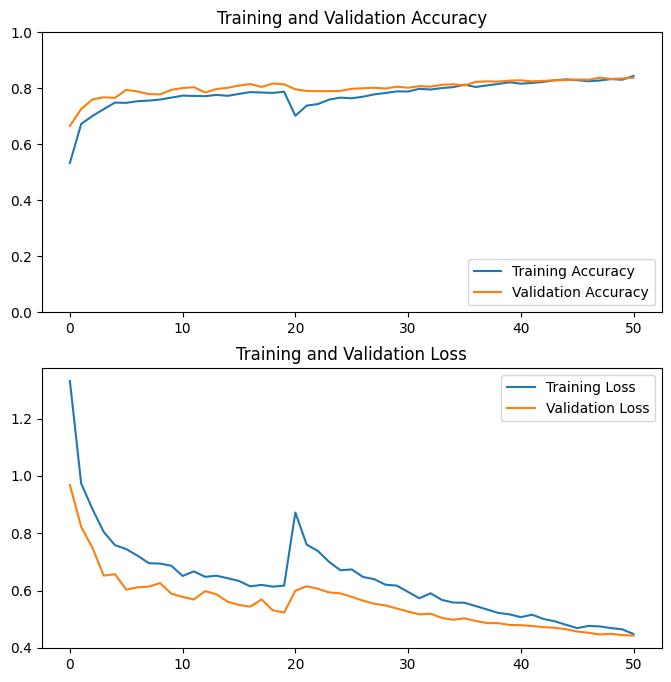

Generating Classification Report...
                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.68      0.84      0.75        76
       2. Brown Blight       0.77      0.74      0.76        96
        3. Gray Blight       0.83      0.84      0.84       192
         4. Helopeltis       0.88      0.72      0.79       130
         5. Red spider       0.81      0.89      0.85        97
    6. Green mirid bug       0.93      0.87      0.90       270
       7. Healthy leaf       0.90      0.98      0.94       194

              accuracy                           0.85      1055
             macro avg       0.83      0.84      0.83      1055
          weighted avg       0.86      0.85      0.85      1055



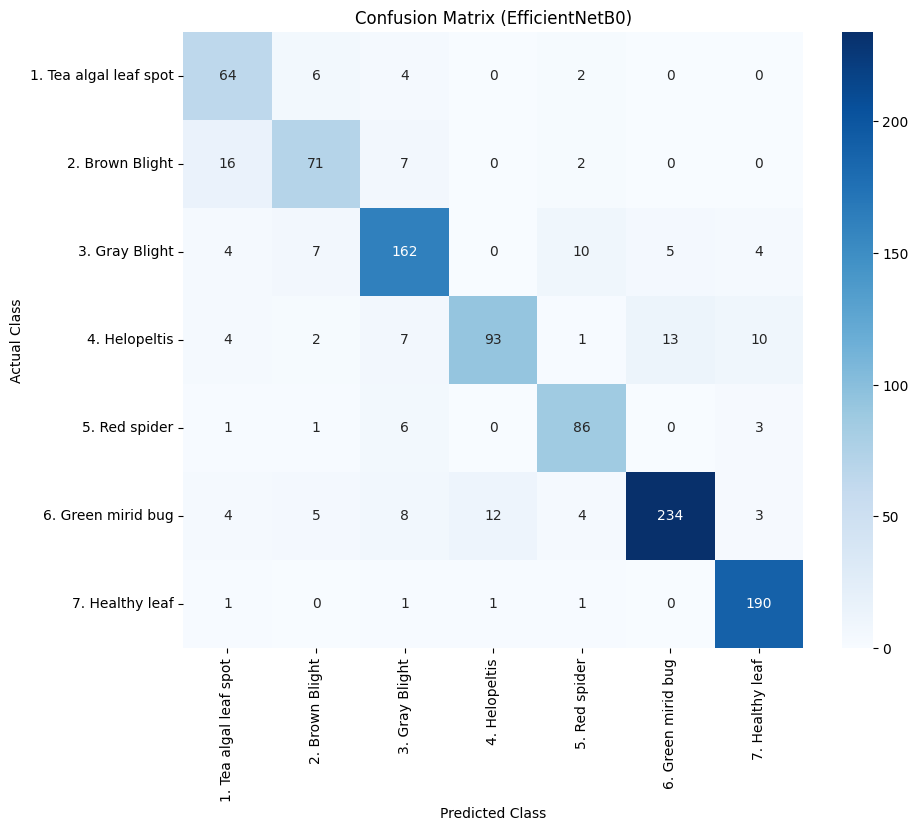

In [ ]:
# 1. Plot Training History
acc = history.history['acc'] + history_fine.history['acc']
val_acc = history.history['val_acc'] + history_fine.history['val_acc']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2. Classification Report
print("Generating Classification Report...")
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.argmax(axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix (EfficientNetB0)')
plt.show()

In [ ]:
import pickle
from google.colab import files

# Save as .keras
model_name = 'tea_leaf_efficientnet.keras'
model.save(model_name)
print(f"Model saved as {model_name}")

# Save class names
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

# Download
files.download(model_name)
files.download('class_names.pkl')

Model saved as tea_leaf_efficientnet.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>